# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9188 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {

    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

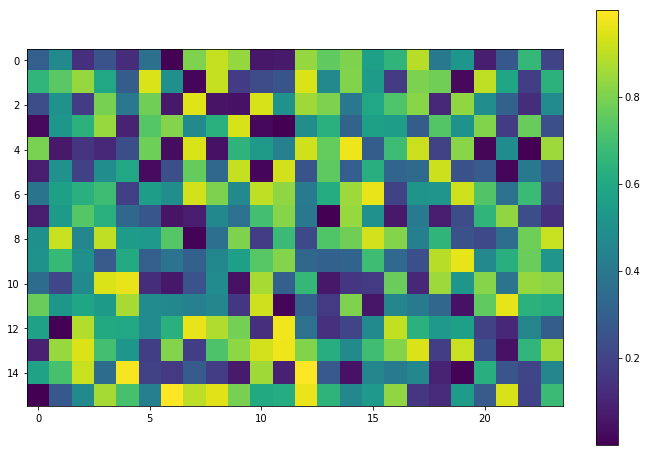

In [5]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
plt.show()

In [26]:
print(a.shape)

(16, 24)


In [6]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [7]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [8]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0])   # now domain size is [x, y]
block_size = (8, 4, 1)   # these need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))


Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [9]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.004482  , 0.59744376, 1.0445153 , 0.587921  , 0.6168157 ,
        0.43737733, 0.10281883, 1.6232245 , 1.8353882 , 0.9891432 ,
        0.310919  , 0.4448145 , 1.1138706 , 1.1791784 , 1.555232  ,
        0.8509283 , 1.2708294 , 1.2504425 , 0.92320573, 0.54293096,
        0.4812964 , 0.46408546, 1.0762022 , 1.1725105 ],
       [1.6120445 , 1.6109538 , 1.2073395 , 1.3896589 , 0.72524273,
        1.5041511 , 1.3494356 , 0.12792253, 1.764331  , 0.38620663,
        1.0828137 , 0.92245424, 1.853759  , 0.70627576, 1.4982018 ,
        1.1132897 , 0.2916474 , 0.84569216, 1.2441529 , 0.9217887 ,
        1.7431755 , 1.5133812 , 1.081547  , 0.6455034 ],
       [0.44617516, 0.88472605, 0.38626516, 1.6284394 , 0.71229035,
        1.6449496 , 1.0572976 , 1.1760999 , 0.33960304, 0.29898593,
        1.5880446 , 1.3379874 , 1.6343027 , 1.4949329 , 0.8380735 ,
        1.1733422 , 1.3787599 , 0.97923225, 0.79616326, 1.1721121 ,
        0.9494343 , 0.9265407 , 0.21898428, 0.87591803],
       [0.311

In [10]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.004482   0.59744376 1.0445153  0.587921   0.6168157  0.43737733
  0.10281883 1.6232245  1.8353882  0.9891432  0.310919   0.4448145
  1.1138706  1.1791784  1.555232   0.8509283  1.2708294  1.2504425
  0.92320573 0.54293096 0.4812964  0.46408546 1.0762022  1.1725105 ]
 [1.6120445  1.6109538  1.2073395  1.3896589  0.72524273 1.5041511
  1.3494356  0.12792253 1.764331   0.38620663 1.0828137  0.92245424
  1.853759   0.70627576 1.4982018  1.1132897  0.2916474  0.84569216
  1.2441529  0.9217887  1.7431755  1.5133812  1.081547   0.6455034 ]
 [0.44617516 0.88472605 0.38626516 1.6284394  0.71229035 1.6449496
  1.0572976  1.1760999  0.33960304 0.29898593 1.5880446  1.3379874
  1.6343027  1.4949329  0.8380735  1.1733422  1.3787599  0.97923225
  0.79616326 1.1721121  0.9494343  0.9265407  0.21898428 0.87591803]
 [0.31106994 1.1533763  1.5382571  1.1625669  1.0822417  1.4257543
  1.7016978  1.3026334  1.4640907  1.2768762  0.10611603 0.95507896
  1.2175252  0.7839614  1.2217057  0.6275415

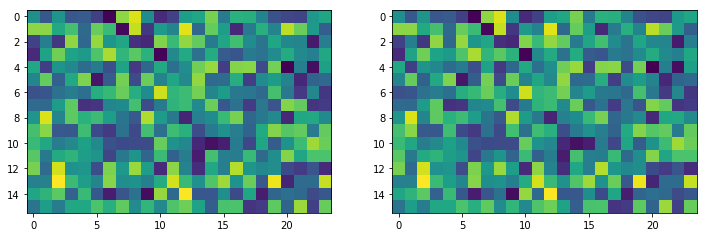

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)